In [1]:
# Install Required Libraries
!pip install yfinance pandas numpy matplotlib scikit-learn tensorflow joblib

In [2]:
# Import Required Libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import os
import json
import joblib
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Set up save directory
save_dir = "/content/drive/MyDrive/stock-predictor"
os.makedirs(save_dir, exist_ok=True)

In [5]:
# Configuration
ticker = 'AAPL'
start_date = '2015-01-01'
end_date = '2024-01-01'
time_step = 60
config = {
    'use_multi_features': False,
    'rolling_days': 30,
    'batch_size': 16,
    'epochs': 20
}

In [6]:
# Data Collection
def get_stock_data(ticker, start, end, use_multi_features):
    data = yf.download(ticker, start=start, end=end, auto_adjust=True)
    if use_multi_features:
        return data[['Open', 'High', 'Low', 'Close', 'Volume']]
    else:
        return data[['Close']]

data = get_stock_data(ticker, start_date, end_date, config['use_multi_features'])

[*********************100%***********************]  1 of 1 completed


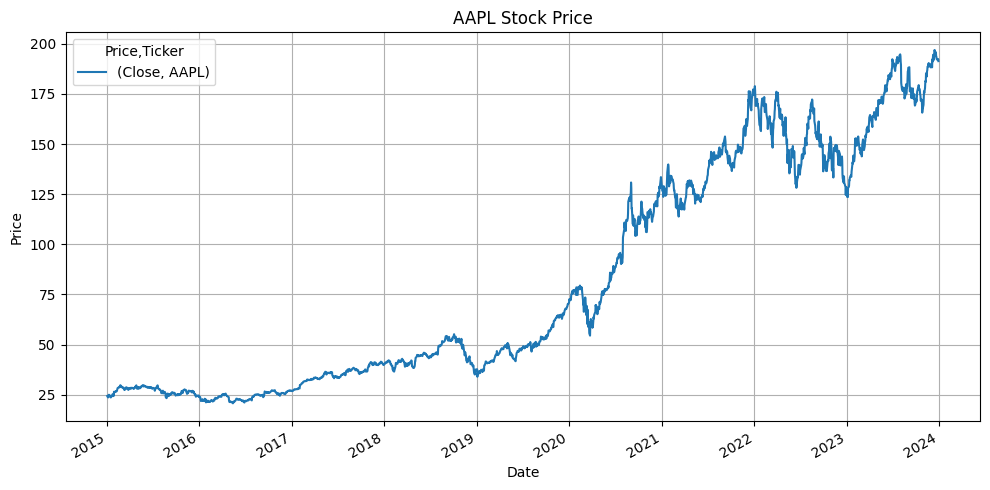

In [7]:
# Data Visualization
plt.figure(figsize=(10,5))
data.plot(ax=plt.gca())
plt.title(f'{ticker} Stock Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid()
plt.tight_layout()
plt.savefig(f"{save_dir}/price_history.png")
plt.show()

In [8]:
# Data Preprocessing
scaler = MinMaxScaler(feature_range=(0,1))
data_scaled = scaler.fit_transform(data)

In [9]:
# Save the scaler
joblib.dump(scaler, f"{save_dir}/scaler.save")

['/content/drive/MyDrive/stock-predictor/scaler.save']

In [10]:
# Creating Sequences
def create_sequences(data, time_step):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i+time_step)])
        y.append(data[i + time_step])
    return np.array(X), np.array(y)

train_size = int(len(data_scaled) * 0.8)
train_data = data_scaled[:train_size]
test_data = data_scaled[train_size-time_step:]

X_train, y_train = create_sequences(train_data, time_step)
X_test, y_test = create_sequences(test_data, time_step)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], data.shape[1]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], data.shape[1]))

In [11]:
# Build Model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(data.shape[1])
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Model checkpointing and early stopping
checkpoint_path = f"{save_dir}/lstm_model.h5"
checkpoint = ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_loss', mode='min')
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [13]:
# Train Model
model.fit(X_train, y_train,
          validation_data=(X_test, y_test),
          epochs=config['epochs'],
          batch_size=config['batch_size'],
          callbacks=[checkpoint, early_stop],
          verbose=1)

Epoch 1/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0244

110/110 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - loss: 0.0243 - val_loss: 0.0031
Epoch 2/20
105/110 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0013

110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 3/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0012 - val_loss: 0.0016
Epoch 4/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0012 - val_loss: 0.0042
Epoch 5/20
107/110 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0013

110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 6/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 8.0820e-04 - val_loss: 0.0035
Epoch 7/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 8.9532e-04 - val_loss: 0.0021
Epoch 8/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 8.7164e-04 - val_loss: 0.0017
Epoch 9/20
108/110 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0011

110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 10/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.1269e-04 - val_loss: 0.0011
Epoch 11/20
107/110 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.0036e-04

110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 8.0134e-04 - val_loss: 9.6966e-04
Epoch 12/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.6694e-04 - val_loss: 0.0022
Epoch 13/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 8.9710e-04 - val_loss: 0.0031
Epoch 14/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.4450e-04 - val_loss: 0.0020
Epoch 15/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.4811e-04 - val_loss: 0.0011
Epoch 16/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 8.0868e-04 - val_loss: 0.0018


In [14]:
# Load best model
model = load_model(checkpoint_path)

In [15]:
# Predictions
predictions = model.predict(X_test)

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


In [16]:
# Inverse Transform
if config['use_multi_features']:
    close_index = list(data.columns).index('Close')
    y_test_inv = scaler.inverse_transform(np.insert(np.zeros((len(y_test), data.shape[1]-1)), close_index, y_test[:, close_index], axis=1))[:, close_index]
    predictions_inv = scaler.inverse_transform(np.insert(np.zeros((len(predictions), data.shape[1]-1)), close_index, predictions[:, close_index], axis=1))[:, close_index]
else:
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))[:, 0]
    predictions_inv = scaler.inverse_transform(predictions.reshape(-1, 1))[:, 0]

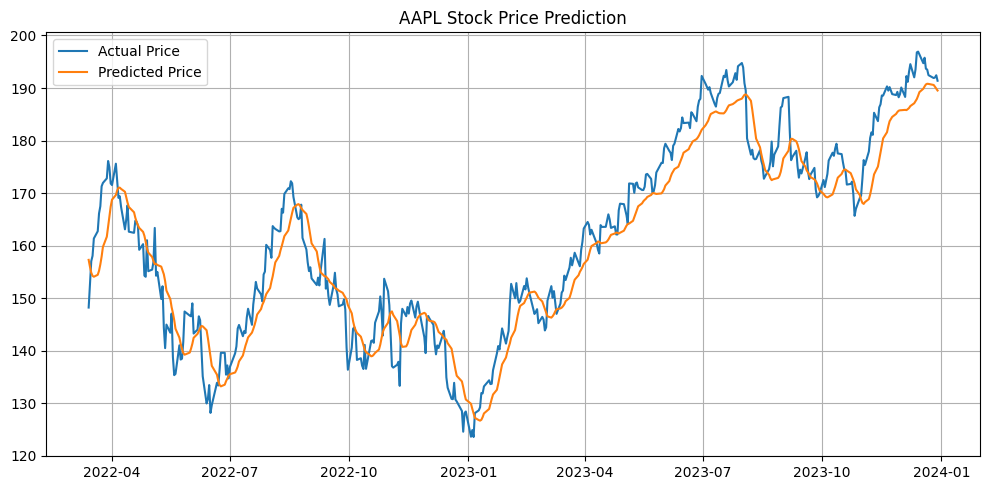

In [17]:
# Plot Predictions
plt.figure(figsize=(10,5))
plt.plot(data.index[-len(y_test):], y_test_inv, label='Actual Price')
plt.plot(data.index[-len(predictions):], predictions_inv, label='Predicted Price')
plt.legend()
plt.title(f'{ticker} Stock Price Prediction')
plt.grid()
plt.tight_layout()
plt.savefig(f"{save_dir}/test_predictions.png")
plt.show()

In [18]:
# Save Predictions to CSV
pred_df = pd.DataFrame({
    'Date': data.index[-len(predictions):],
    'Actual': y_test_inv,
    'Predicted': predictions_inv
})
pred_df.to_csv(f"{save_dir}/{ticker}_predictions.csv", index=False)

In [19]:
# Future Forecasting
def forecast_next_days(model, last_sequence, scaler, future_days=30):
    forecasted = []
    current_seq = last_sequence.copy()
    for _ in range(future_days):
        pred = model.predict(current_seq.reshape(1, time_step, data.shape[1]), verbose=0)
        forecasted.append(pred[0])
        current_seq = np.append(current_seq[1:], pred, axis=0)
    forecasted = np.array(forecasted)
    if config['use_multi_features']:
        close_index = list(data.columns).index('Close')
        forecasted_inv = scaler.inverse_transform(np.insert(np.zeros((future_days, data.shape[1]-1)), close_index, forecasted[:, close_index], axis=1))[:, close_index]
    else:
        forecasted_inv = scaler.inverse_transform(forecasted.reshape(-1, 1))[:, 0]
    return forecasted_inv

last_sequence = data_scaled[-time_step:]
future_forecast = forecast_next_days(model, last_sequence, scaler, config['rolling_days'])

In [20]:
# Future Dates
last_date = data.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=config['rolling_days'], freq='B')

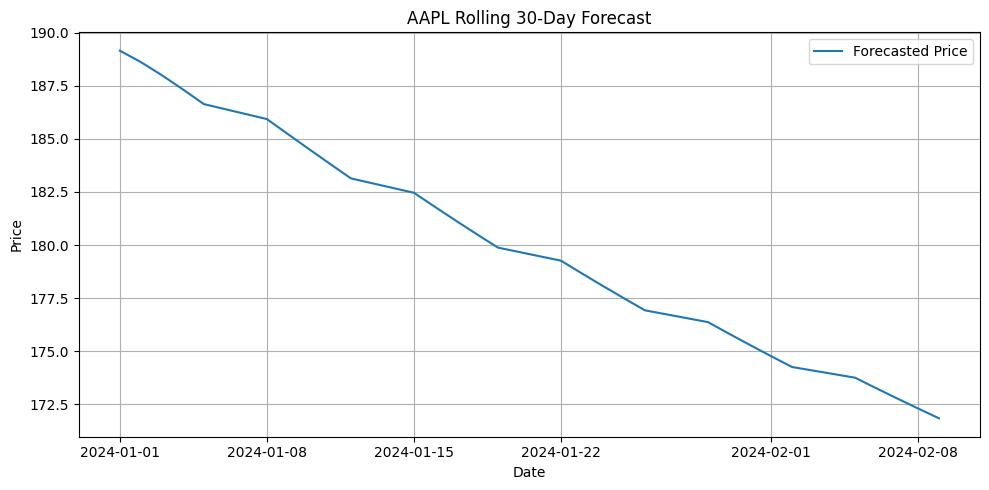

In [21]:
# Plot Future Forecast
plt.figure(figsize=(10,5))
plt.plot(future_dates, future_forecast, label='Forecasted Price')
plt.title(f'{ticker} Rolling {config["rolling_days"]}-Day Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig(f"{save_dir}/future_forecast.png")
plt.show()

In [22]:
# Save Future Forecast to CSV
future_df = pd.DataFrame({
    'Date': future_dates,
    'Forecasted_Price': future_forecast
})
future_df.to_csv(f"{save_dir}/{ticker}_future_forecast.csv", index=False)

In [23]:
# Evaluation Metrics
rmse = np.sqrt(mean_squared_error(y_test_inv, predictions_inv))
mae = mean_absolute_error(y_test_inv, predictions_inv)

print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')

RMSE: 5.49
MAE: 4.64


In [24]:
# Save Metadata
metadata = {
    'ticker': ticker,
    'start_date': start_date,
    'end_date': end_date,
    'time_step': time_step,
    'multi_features': config['use_multi_features'],
    'rolling_days': config['rolling_days'],
    'epochs': config['epochs'],
    'batch_size': config['batch_size'],
    'RMSE': rmse,
    'MAE': mae
}
with open(f"{save_dir}/config_metrics.json", "w") as f:
    json.dump(metadata, f, indent=4)

print("✅ All files saved to Google Drive folder: stock-predictor")

✅ All files saved to Google Drive folder: stock-predictor
